# Introduction
<center><img src="https://i.hizliresim.com/lm492qd.png" alt="Görsel" style="max-width: 100%; height: 400px;"> <center>
    <br>

<center> <b> It attempts to solve the problem of recognizing gender from human faces using Convolutional Neural Networks (CNN), one of the deep learning methods. <b><center>

# Importing Modules and Libraries

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import cv2


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model, to_categorical, load_img
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Cropping2D, Resizing, concatenate

# Loading the Dataset

In [4]:
BASE_DIR='/kaggle/input/utkface-new/UTKFace/'
image_paths = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    gender = int(temp[1])
    image_paths.append(image_path)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

# Exploratory Data Analysis

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['gender'] = image_paths, gender_labels
df.head()

,image,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,1


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

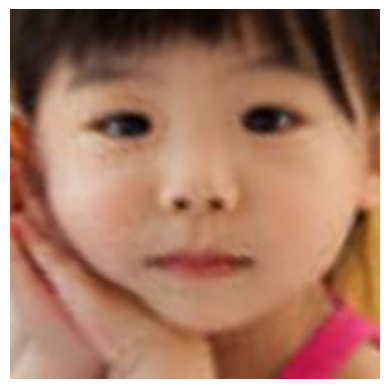

In [7]:
from PIL import Image
img = Image.open(df['image'][100])
plt.axis('off')
plt.imshow(img);

<Axes: ylabel='count'>

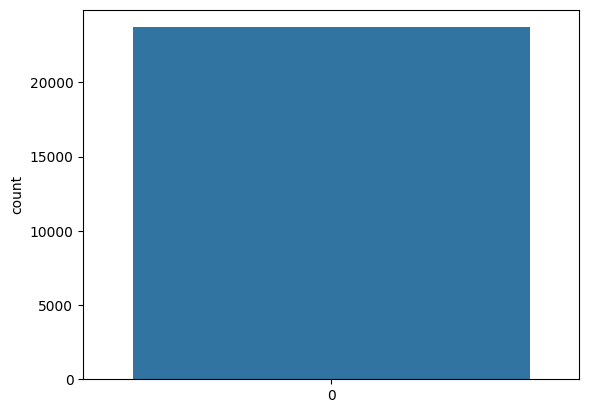

In [8]:
sns.countplot(df['gender'])

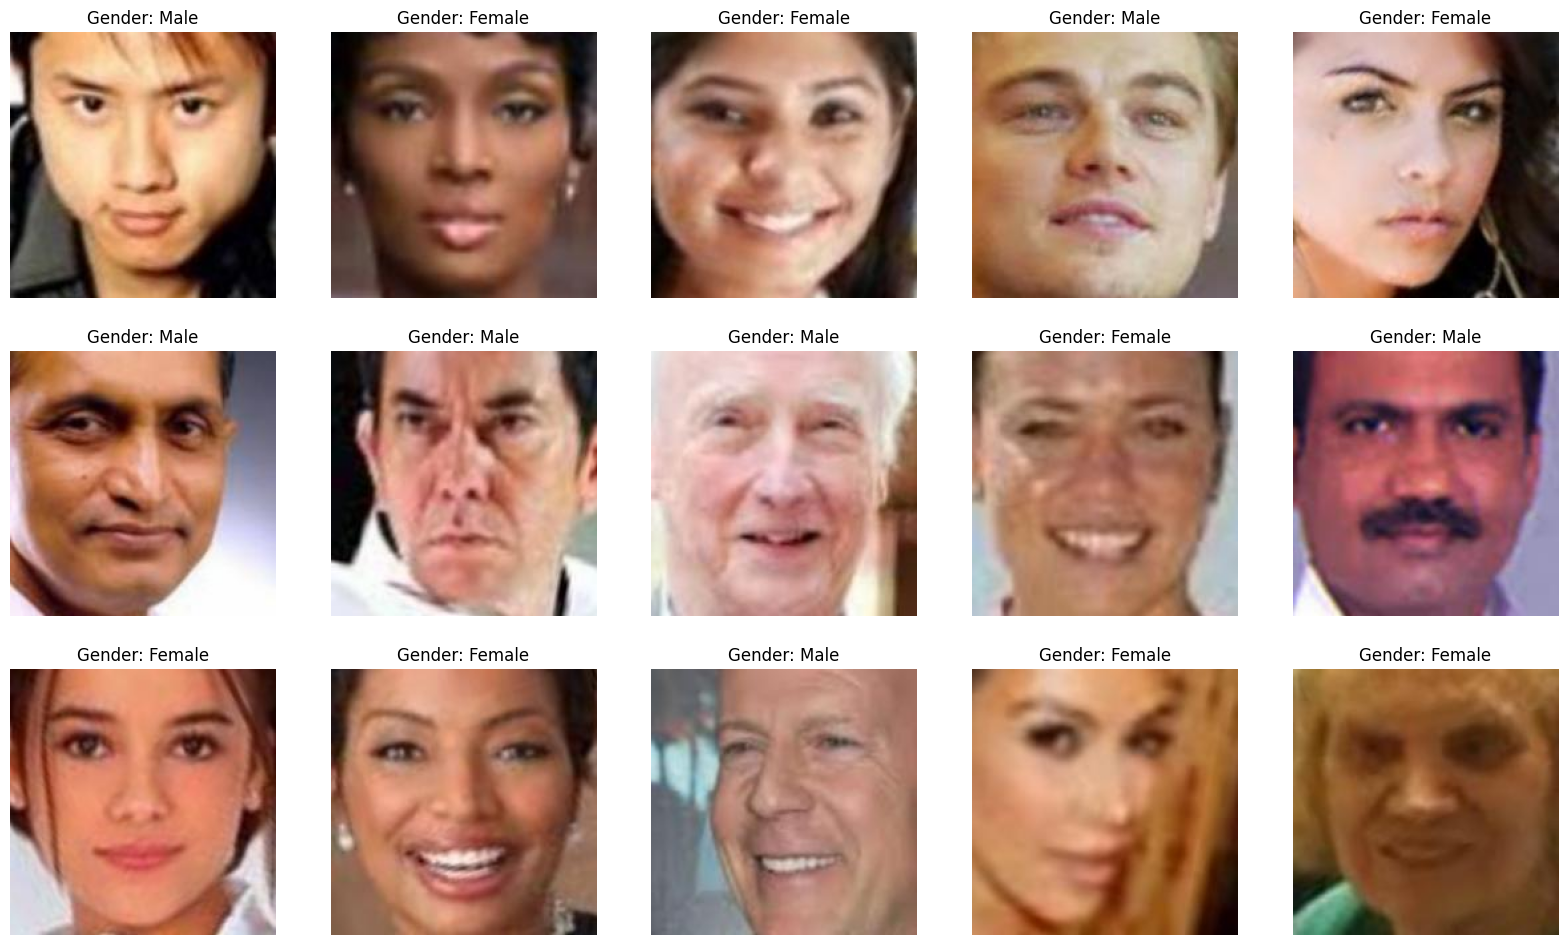

In [9]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:15]

for index, file, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Gender: {gender_dict[gender]}")
    plt.axis('off')

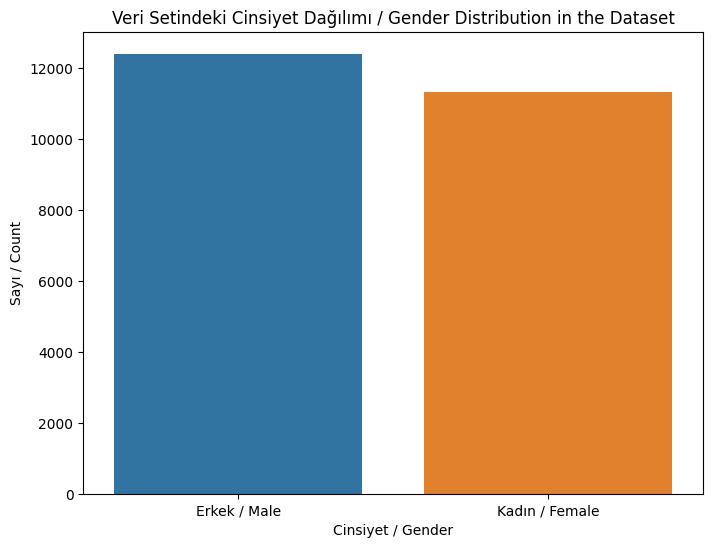

In [10]:
# Veri Setindeki Cinsiyet Dağılımı / Gender Distribution in the Dataset
plt.figure(figsize=(8, 6))
plt.title("Veri Setindeki Cinsiyet Dağılımı / Gender Distribution in the Dataset")
sns.countplot(x='gender', data=df)
plt.xlabel("Cinsiyet / Gender")
plt.ylabel("Sayı / Count")
plt.xticks(ticks=[0, 1], labels=["Erkek / Male", "Kadın / Female"])
plt.show()

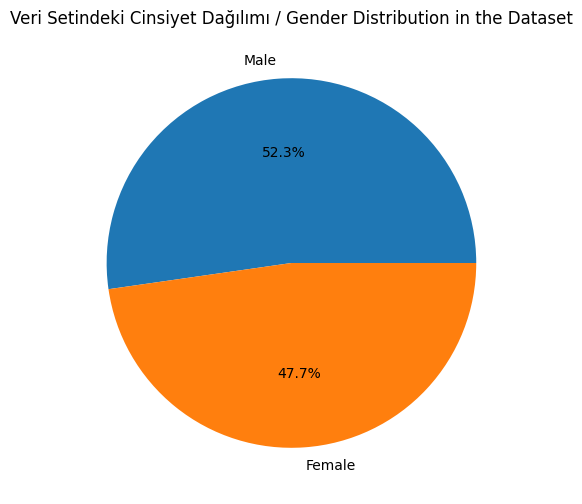

In [11]:
plt.figure(figsize=(8, 6))
plt.title("Veri Setindeki Cinsiyet Dağılımı / Gender Distribution in the Dataset")
gender_counts = df['gender'].map(gender_dict).value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.show()

# Feature Extraction

In [12]:
IMG_SIZE, CHANNEL = 128, 1
VAL_SPLIT = 0.2
LR_RATE = 2e-4
INITIAL_LEARN_RATE = 0.1
DECAY_STEP, DECAY_RATE = 1e5, 0.96
OPTIM = 0.0001
BATCH_SIZE, EPOCH = 16,5

In [3]:

np.random.seed(42)
tf.random.set_seed(42)


BATCH_SIZE = 32
IMAGE_SIZE = 224

In [13]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    features = features.reshape(len(features), IMG_SIZE, IMG_SIZE, CHANNEL)
    return features
X = extract_features(df['image'])
X.shape

  0%|          | 0/23708 [00:00<?, ?it/s]

(23708, 128, 128, 1)

In [15]:
X = X/255.0
y_gender = np.array(df['gender'])
input_shape = (IMG_SIZE, IMG_SIZE, CHANNEL)
inputs = Input((input_shape))

# Model Creation

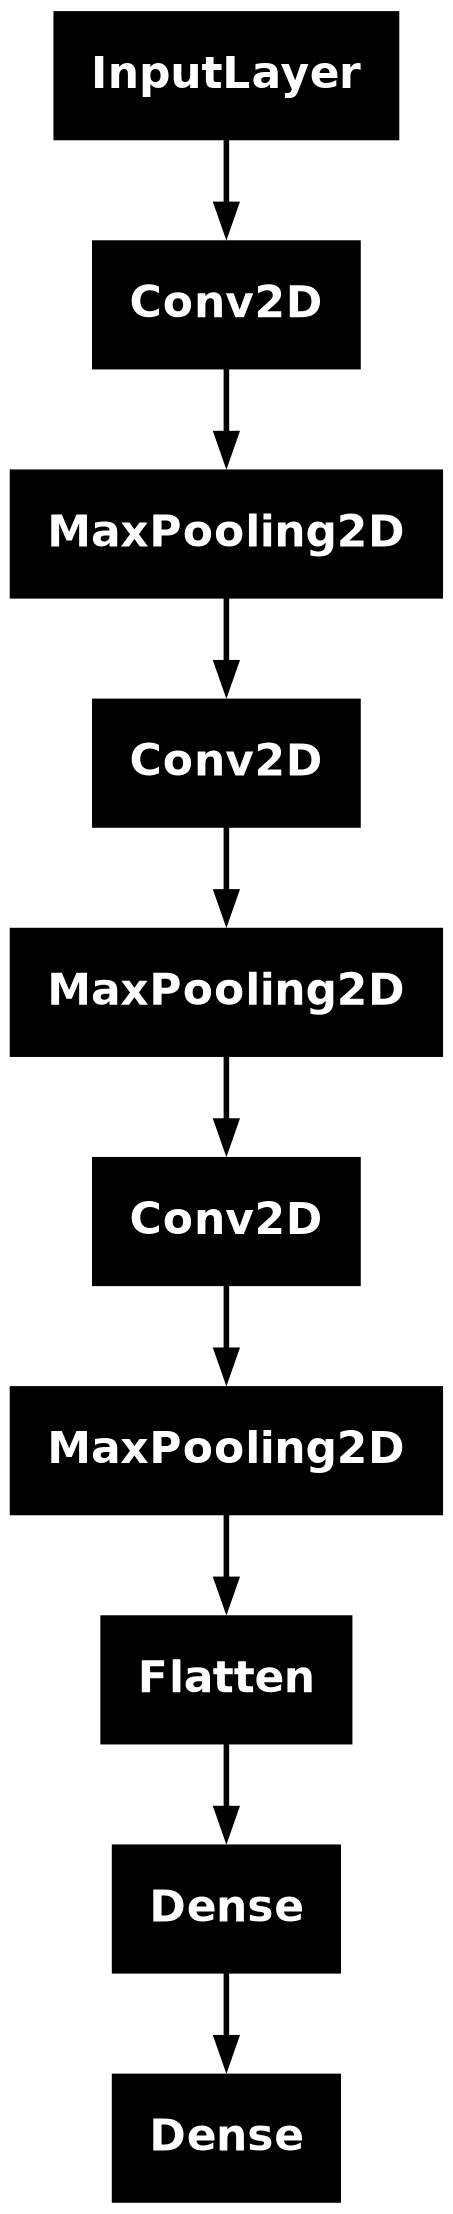

In [16]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
flatten = Flatten()(pool3)
dense1 = Dense(256, activation='relu')(flatten)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=inputs, outputs=output)

# Compile Model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


plot_model(model)

In [17]:
history = model.fit(X, y_gender, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

Epoch 1/5
  18/1186 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4673 - loss: 0.8570

I0000 00:00:1713017021.224982      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713017021.241049      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7579 - loss: 0.4818

W0000 00:00:1713017036.175112      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1186/1186 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.7579 - loss: 0.4817 - val_accuracy: 0.8385 - val_loss: 0.3409
Epoch 2/5
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8701 - loss: 0.2994 - val_accuracy: 0.8699 - val_loss: 0.2834
Epoch 3/5
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8967 - loss: 0.2475 - val_accuracy: 0.8832 - val_loss: 0.2694
Epoch 4/5
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9158 - loss: 0.2011 - val_accuracy: 0.8870 - val_loss: 0.2715
Epoch 5/5
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9418 - loss: 0.1502 - val_accuracy: 0.8838 - val_loss: 0.3111


# Plot the results

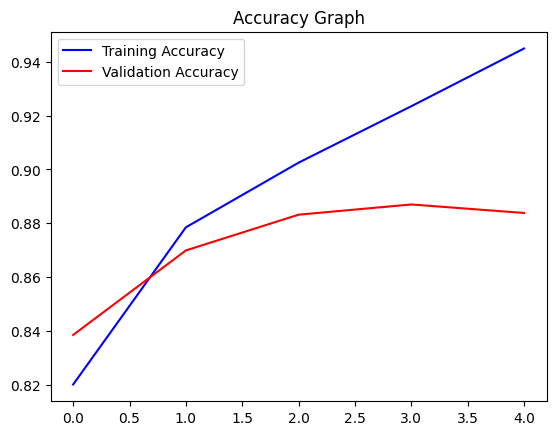

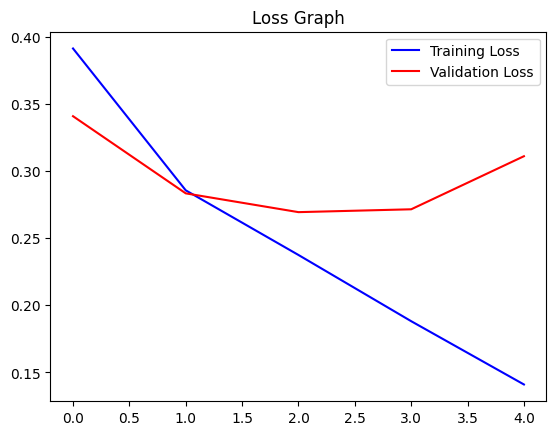

In [18]:

# plot results for gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction

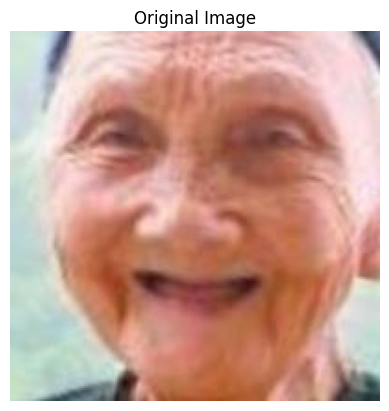

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


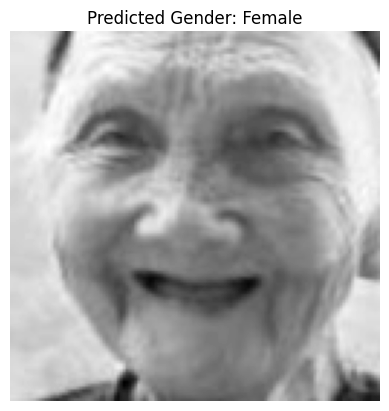

In [30]:

image_path='/kaggle/input/utkface-new/crop_part1/101_1_2_20170105174739309.jpg.chip.jpg'
# EN: Read the image in grayscale
# TR: Gri tonlamalı olarak görseli oku
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# EN: Read the original image
# TR: Orijinal görüntüyü oku
org_image = cv2.imread(image_path)

# EN: Resize the image to fit the model
# TR: Görüntüyü modele uygun boyuta yeniden boyutlandır
resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

# EN: Reshape the image to match the model's input shape
# TR: Görüntüyü modele uygun formata dönüştür
reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# EN: Display the original image with its original colors
# TR: Orijinal renkleriyle görüntüyü göster
plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

# EN: Make a prediction using the reshaped image
# TR: Dönüştürülmüş görüntüyle tahmin yap
pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

# EN: Display the resized image with the predicted gender
# TR: Yeniden boyutlandırılmış görüntüyü ve tahmin edilen cinsiyeti göster
plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

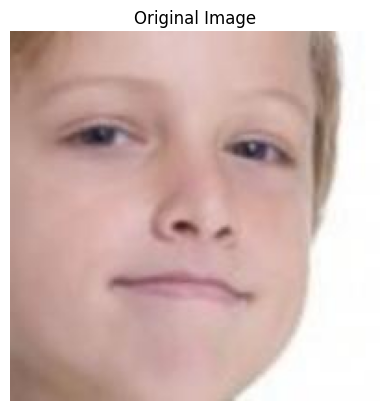

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


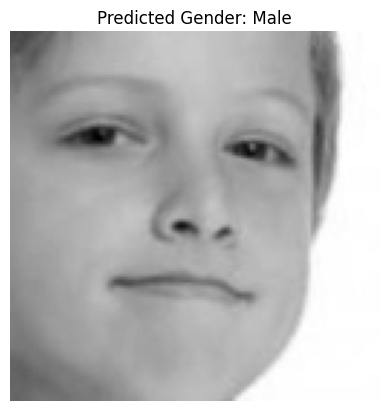

In [31]:

image_path='/kaggle/input/utkface-new/crop_part1/14_0_0_20170110225712028.jpg.chip.jpg'
# EN: Read the image in grayscale
# TR: Gri tonlamalı olarak görseli oku
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# EN: Read the original image
# TR: Orijinal görüntüyü oku
org_image = cv2.imread(image_path)

# EN: Resize the image to fit the model
# TR: Görüntüyü modele uygun boyuta yeniden boyutlandır
resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

# EN: Reshape the image to match the model's input shape
# TR: Görüntüyü modele uygun formata dönüştür
reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# EN: Display the original image with its original colors
# TR: Orijinal renkleriyle görüntüyü göster
plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

# EN: Make a prediction using the reshaped image
# TR: Dönüştürülmüş görüntüyle tahmin yap
pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

# EN: Display the resized image with the predicted gender
# TR: Yeniden boyutlandırılmış görüntüyü ve tahmin edilen cinsiyeti göster
plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

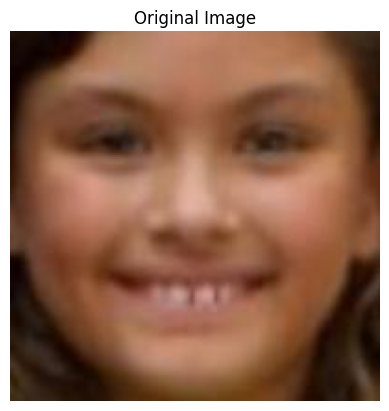

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


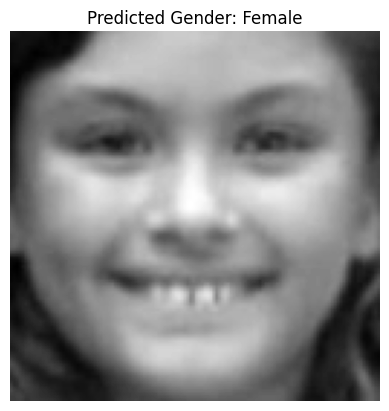

In [32]:
image_path='/kaggle/input/utkface-new/crop_part1/11_1_4_20170109201611941.jpg.chip.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

org_image = cv2.imread(image_path)

resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

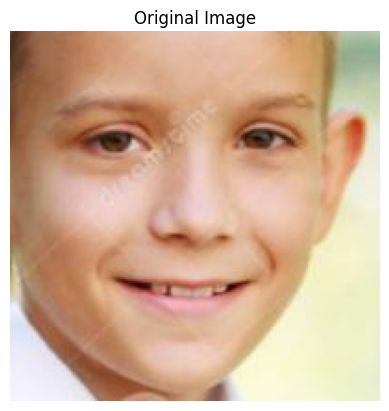

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


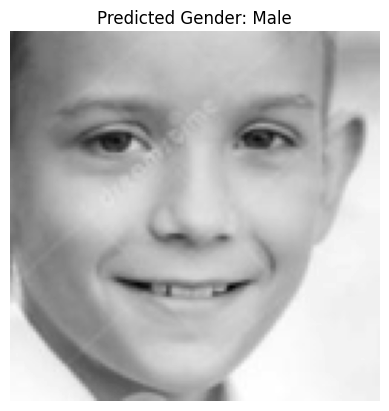

In [33]:
image_path='/kaggle/input/utkface-new/crop_part1/10_0_0_20170110220546177.jpg.chip.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

org_image = cv2.imread(image_path)

resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

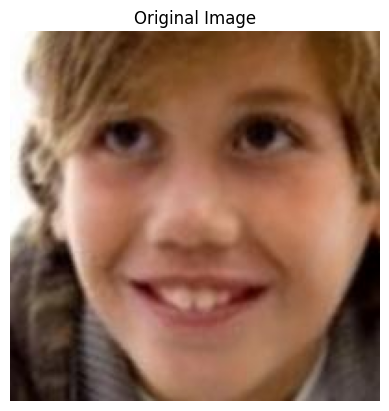

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


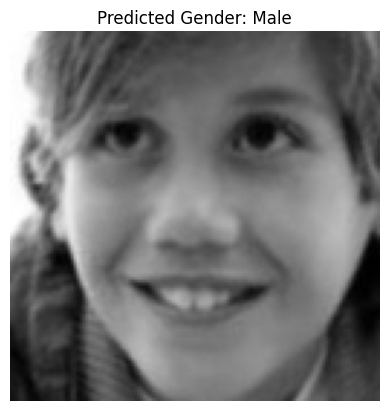

In [34]:
image_path='/kaggle/input/utkface-new/crop_part1/10_0_0_20170110220539329.jpg.chip.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

org_image = cv2.imread(image_path)

resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

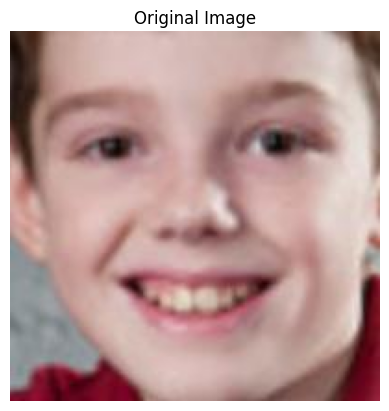

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


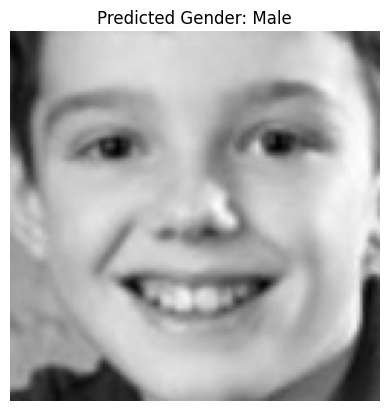

In [35]:
image_path='/kaggle/input/utkface-new/crop_part1/10_0_0_20170110225444491.jpg.chip.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

org_image = cv2.imread(image_path)

resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

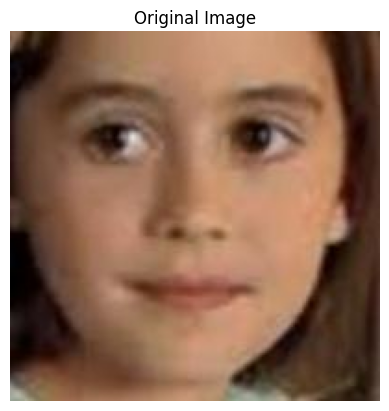

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


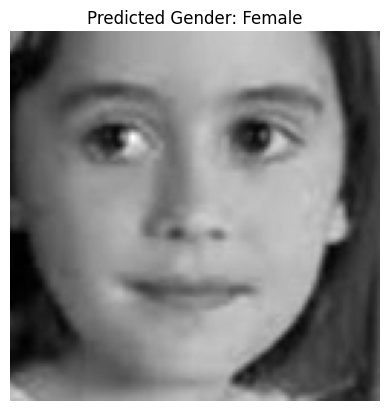

In [36]:
image_path='/kaggle/input/utkface-new/crop_part1/10_1_0_20170103175323250.jpg.chip.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

org_image = cv2.imread(image_path)

resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()

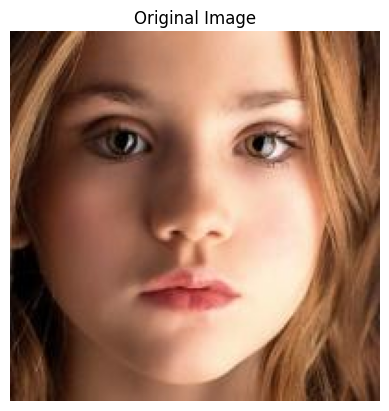

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


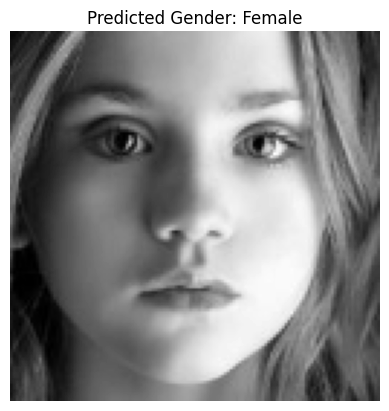

In [37]:
image_path='/kaggle/input/utkface-new/crop_part1/10_1_0_20170109204844109.jpg.chip.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

org_image = cv2.imread(image_path)

resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

reshaped_image = resized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
plt.show()

pred = model.predict(reshaped_image)
pred_gender = "Female" if pred[0][0] > 0.5 else "Male"

plt.title(f"Predicted Gender: {pred_gender}")
plt.axis('off')
plt.imshow(resized_image, cmap='gray')
plt.show()